In [2]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import math
import json

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.scripts.eval import eval_setup

# Implementation

In [3]:
config_path = Path(
    "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/config.yml")
_, pipeline, _, _ = eval_setup(config_path=config_path, test_mode="inference")
nerf_model = pipeline.model
nerf_device = nerf_model.device

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/nerfstudio_models/step-000018000.ckpt

In [4]:
dataparser_transforms_path = Path(
    "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/dataparser_transforms.json")

with open(dataparser_transforms_path, "r") as f:
    dataparser_transform = json.load(f)

dataparser_matrix = torch.tensor(dataparser_transform["transform"], dtype=torch.float32)
dataparser_matrix = np.vstack((dataparser_matrix, np.array([[0, 0, 0, 1]])))
dataparser_scale = dataparser_transform["scale"]

In [5]:
data_transform_matrix = np.array([
    [-0.16551750084030392, 0.17173068552312126, -0.9711398089695112, -80.73672706466026],
    [-0.9756847655052445, 0.11494663876681419, 0.18661861803471735, 15.51473463480075],
    [0.14367740002017088, 0.9784149640546033, 0.14852933325600515, 12.348141976499424],
    [0, 0, 0, 1],
])

camera_params = {
    "camera_angle_x": 0.5235987755982988,
    "camera_angle_y": 0.5235987755982988,
    "fl_x": 955.4050067376327,
    "fl_y": 955.4050067376327,
    "k1": 0,
    "k2": 0,
    "k3": 0,
    "k4": 0,
    "p1": 0,
    "p2": 0,
    "is_fisheye": False,
    "cx": 256.0,
    "cy": 256.0,
    "w": 512,
    "h": 512,
    "aabb_scale": 32,
}

In [6]:
final_matrix = np.dot(dataparser_matrix, data_transform_matrix)
final_matrix[:3, 3] = final_matrix[:3, 3] * dataparser_scale
final_matrix = nn.Parameter(torch.tensor(final_matrix, dtype=torch.float32), requires_grad=True)[:3, :4]
final_matrix, final_matrix.shape

# should look like this:
# actual_transform_matrix = np.array([
#     [-0.2205035537481308, -0.21815498173236847, -0.9506769180297852, -0.11759857088327408],
#     [-0.9667345285415649, 0.17840947210788727, 0.1832878142595291, 0.23202396929264069],
#     [0.129624605178833, 0.9594677686691284, -0.2502378523349762, -0.26915040612220764],
#     [0, 0, 0, 1]
# ])

(tensor([[-0.2205, -0.2182, -0.9507, -0.1176],
         [-0.9667,  0.1784,  0.1833,  0.2320],
         [ 0.1296,  0.9595, -0.2502, -0.2692]], grad_fn=<SliceBackward0>),
 torch.Size([3, 4]))

In [7]:
camera = Cameras(
    camera_to_worlds=final_matrix.unsqueeze(0), # 1x3x4 tensor
    fx=camera_params["fl_x"],
    fy=camera_params["fl_y"],
    cx=camera_params["cx"],
    cy=camera_params["cy"],
    camera_type=CameraType.PERSPECTIVE,
    height=camera_params["h"],
    width=camera_params["w"],
)

# ray_bundle = camera.generate_rays(torch.tensor([0]), keep_shape=True)
# ray_bundle.origins = ray_bundle.origins.to(nerf_device)
# ray_bundle.directions = ray_bundle.directions.to(nerf_device)

In [9]:
# ray_bundle.origins.shape

torch.Size([512, 512, 3])

In [10]:
nerf_model.train(True)

for param in nerf_model.parameters():
    param.requires_grad = False
    
nerf_model.zero_grad()

In [11]:
# print(torch.cuda.is_available())
# print(torch.version.cuda)
# 
# print(torch.cuda.memory_allocated())
# print(torch.cuda.memory_reserved())
# 
# print(ray_bundle.origins.device)
# print(ray_bundle.directions.device)
# print(next(nerf_model.parameters()).device)

True
11.8
342880256
346030080
cuda:0
cuda:0
cuda:0


In [15]:
torch.cuda.empty_cache()


In [13]:
# ray_bundle.origins = ray_bundle.origins.reshape(-1, 3)
# ray_bundle.directions = ray_bundle.directions.reshape(-1, 3)
# 
# nerf_model.forward(ray_bundle)

RuntimeError: /tmp/pip-req-build-wge5j99g/include/tiny-cuda-nn/gpu_memory.h:584 cuMemCreate(&m_handles.back(), n_bytes_to_allocate, &prop, 0) failed: CUDA_ERROR_OUT_OF_MEMORY

In [ ]:
# ray_bundle.origins.ndim, ray_bundle.directions.shape, ray_bundle.directions.ndim, ray_bundle.directions.shape

In [8]:
outputs = nerf_model.get_outputs_for_camera(camera)
generated_rgb = outputs["rgb"]

In [ ]:
generated_rgb.device

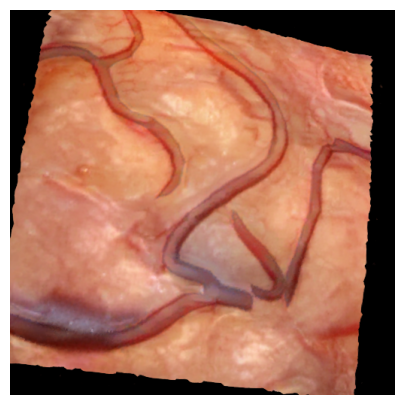

In [9]:
plt.figure(figsize=(5, 5))
plt.imshow(np.array(generated_rgb))
plt.axis('off')
plt.show()

# generated_image = Image.fromarray((generated_rgb[0] * 255).astype(np.uint8))
# generated_image.save("generated_image.png")

### Training

In [ ]:
device = nerf_device

In [ ]:
# 1. Extracting the target image

def image_to_tensor(image_path, device=nerf_device):
    # Open the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Define the transform to convert the image to a PyTorch tensor
    transform = transforms.ToTensor()  # This will convert to a tensor with shape (C, H, W)

    # Apply the transform
    tensor = transform(image)  # Shape will be (3, 512, 512)

    # Permute the tensor to get shape (512, 512, 3)
    tensor = tensor.permute(1, 2, 0).to(device)

    return tensor

target_image = image_to_tensor("/n/home10/dpodolskyi/neural-registration/data/datasets/0_065_cat5_2.0/images/4.png")

In [ ]:
target_image.shape

In [ ]:
# 2. Create camera object
camera_to_world_param = torch.nn.Parameter(torch.tensor(final_matrix[:3, :4], dtype=torch.float32, device=device))

optimized_camera = Cameras(
    camera_to_worlds=camera_to_world_param,
    fx=camera_params["fl_x"],
    fy=camera_params["fl_y"],
    cx=camera_params["cx"],
    cy=camera_params["cy"],
    camera_type=CameraType.PERSPECTIVE,
    height=camera_params["h"],
    width=camera_params["w"],
)

In [9]:
# 3. Set up the optimizer
optimizer = torch.optim.Adam([final_matrix], lr=0.001)

ValueError: can't optimize a non-leaf Tensor

In [ ]:
# 3. Calculate the loss function
mse_loss = nn.MSELoss()

outputs = nerf_model.get_outputs_for_camera(optimized_camera)
generated_rgb = outputs["rgb"]

loss = mse_loss(generated_rgb, target_image)

In [ ]:
# 4. Calculate gradients
loss.backward()

# Misc

In [ ]:
def extract_translation_rotation(transform_matrix):
    def rotation_matrix_to_euler_angles(R):
        sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
        singular = sy < 1e-6

        if not singular:
            x = math.atan2(R[2, 1], R[2, 2])
            y = math.atan2(-R[2, 0], sy)
            z = math.atan2(R[1, 0], R[0, 0])
        else:
            x = math.atan2(-R[1, 2], R[1, 1])
            y = math.atan2(-R[2, 0], sy)
            z = 0

        return np.array([x, y, z])

    # Extract translation
    translation = transform_matrix[:3, 3]

    # Extract rotation matrix
    rotation_matrix = transform_matrix[:3, :3]

    # Get Euler angles
    euler_angles = rotation_matrix_to_euler_angles(rotation_matrix)

    # Convert to degrees
    euler_angles_deg = np.degrees(euler_angles)

    return translation, euler_angles_deg


translation, rotation = extract_translation_rotation(transform_matrix)

print("Translations (x, y, z):", translation)
print("Rotation angles (in degrees):")
print("Roll (x-axis):", rotation[0])
print("Pitch (y-axis):", rotation[1])
print("Yaw (z-axis):", rotation[2])

In [ ]:
from pathlib import Path

config_path = Path(
    "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/nerfacto/2024-08-20_111705/config.yml")

# Read and print the content of the file
with open(config_path, 'r') as file:
    content = file.read()
    print(content)